In [7]:
#installs
!pip install xlrd
!pip install uncertainties

In [8]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib as mpl
import uncertainties as unc
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit

In [9]:
# define plot params
# plt.style.use("Source.mplstyle")
# plt.rc('text', usetex=True)  # enable use of LaTeX in matplotlib
# plt.rc('font', family="serif", size=14)  # font settings

# mpl.rcParams["axes.labelpad"] = 10

In [10]:
h, w = 1024, 1536

In [11]:
def load_data(file):
    hdul = fits.open(file)
    data = hdul[0].data
    return data

def plot_data(ax, data, cmap="seismic", **cbar_kwargs):
    ax.imshow(data, cmap=cmap, origin="lower")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax.images[0], cax=cax, **cbar_kwargs)
    # plt.show()


# calculate mean of multiple images
def calc_mean(file, stop, start=2):
    arr = np.zeros((h, w, stop-start))
    for i in range(start, stop):
        arr[:, :, i-start] = load_data(f"{file}_{i}.fits")
    mean = np.mean(arr, axis=2)
    return mean

# plot histogram of data
def plot_hist(ax, data, **kwargs):
    binarr = data.flatten()
    ax.hist(binarr, bins=range(int(min(binarr)), int(max(binarr)), 1), color='white', edgecolor='black', histtype='stepfilled', **kwargs)
    # plt.show()

def plot_rect(ax, x, y, w, h):
    ax.plot([x, x], [y, y+h], color='red')
    ax.plot([x, x+w], [y, y], color='red')
    ax.plot([x, x+w], [y+h, y+h], color='red')
    ax.plot([x+w, x+w], [y, y+h], color='red')

# cut out a windwo of pixels
def cut_window(data, x, y, w, h):
    return data[y:y+h, x:x+w]


def parabola(x, a, b, c):
    return a*x**2 + x/b + c


def parabola2(x, a, b):
    return a*x**2 + x/b + std_ron


def line(x, a, b):
    return a*x + b

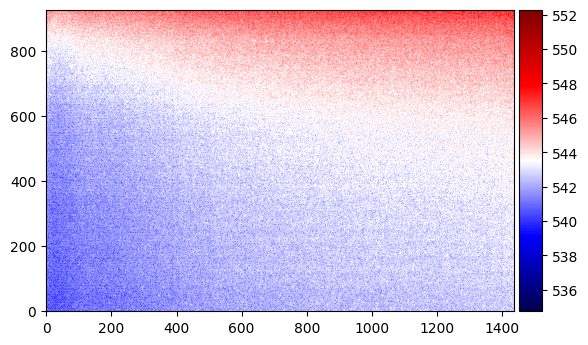

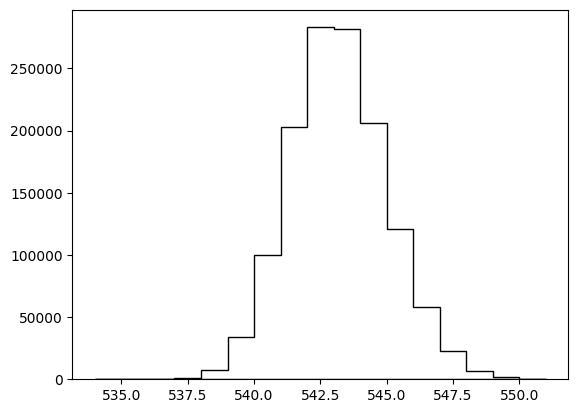

In [12]:
# load 20 bias images and calculate the mean for each pixel
bias = calc_mean("biasa1", 22)
# exclude 50 first and 50 last pixels in x and y direction
bias = bias[50:-50, 50:-50]
fig, ax = plt.subplots()
plot_data(ax, bias)

fit, ax = plt.subplots()
# plot histogram of bias values, with binsize 1
plot_hist(ax, bias)

Mean of bias: 543.1682283188028
Standard deviation of bias: 1.812105478210128
Mean of data: -0.09061297917495678
Standard deviation of data: 5.9357950423224555


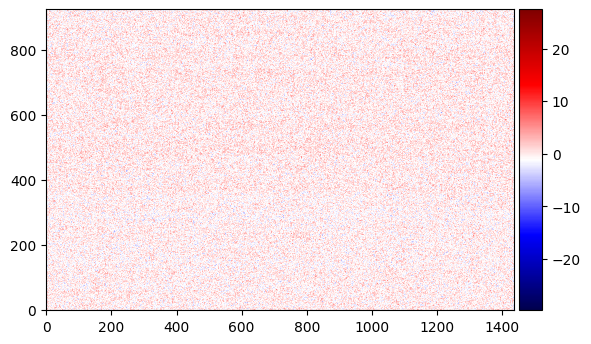

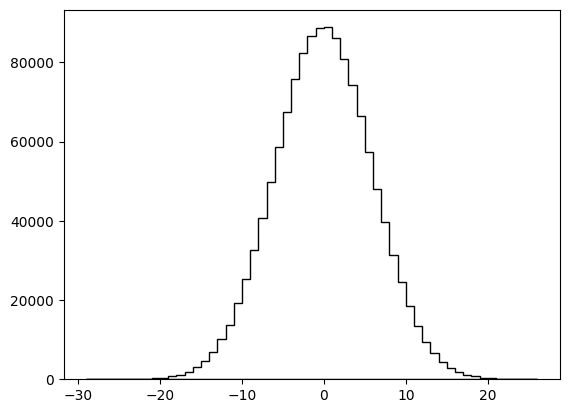

In [13]:
# =============== Ex1 ===============
# calculate mean and std_dev of bias
mean_bias = np.mean(bias)
std_dev_bias = np.std(bias)
print(f"Mean of bias: {mean_bias}")
print(f"Standard deviation of bias: {std_dev_bias}")

# subtract the bias from one image
data = load_data("biasa1_13.fits")
data = data[50:-50, 50:-50] - bias
fig, ax = plt.subplots()
plot_data(ax, data)
fit, ax = plt.subplots()
plot_hist(ax, data)

std_ron = np.std(data)
mean_ron = np.mean(data)
print(f"Mean of data: {mean_ron}")
print(f"Standard deviation of data: {std_ron}")

Mean of Green flat: 2695.973725
Standard deviation of Green flat: 36.80134175032719
g factor of Green flat: 1.990619935961093


<ipython-input-14-6808d96d91da>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([0, 600, 650, 700, 750])
<ipython-input-14-6808d96d91da>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([0, 150, 200, 350, 400])


Mean of Blue flat: 1566.24928
Standard deviation of Blue flat: 28.499546934672487
g factor of Blue flat: 1.9283460493789273


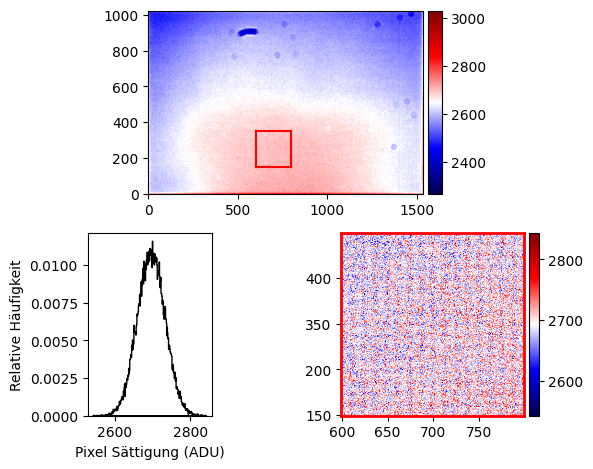

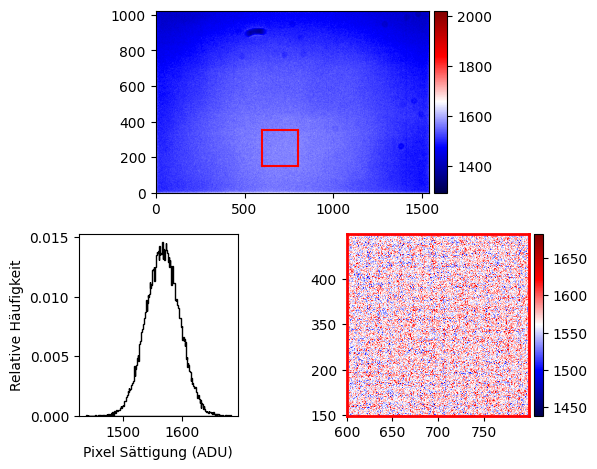

In [14]:
# ================== Ex2 ==================
g_all = np.zeros(2)
for (i, color) in enumerate(["Green", "Blue"]):
    # load bias frames
    bias = calc_mean(f"biasa_{color}_A4", 7)
    # load flat frame
    flat = load_data(f"{color}_light_A3_flat.fits")
    # correct flat frame
    flat = flat - bias
    # plot flat frame
    # plot_data(flat)

    # calculate g factor from mean and std_dev of flat frame cutting out a window
    cutflat = cut_window(flat, 600, 150, 200, 200)
    mean_flat = np.mean(cutflat)
    std_dev_flat = np.std(cutflat)
    g = mean_flat / std_dev_flat**2
    g_all[i] = g
    print(f"Mean of {color} flat: {mean_flat}")
    print(f"Standard deviation of {color} flat: {std_dev_flat}")
    print(f"g factor of {color} flat: {g}")

    fig = plt.figure()

    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    plot_data(ax1, flat)
    # plot red rectangle
    plot_rect(ax1, 600, 150, 200, 200)

    plot_data(ax3, cutflat)
    plot_hist(ax2, cutflat, density=True)

    ax2.set_xlabel("Pixel Sättigung (ADU)")
    ax2.set_ylabel("Relative Häufigkeit")

    # change width of ax2
    if i != 0:
        ax2.set_aspect(20000)
    else:
        ax2.set_aspect(40000)
    plt.tight_layout()

    # offset ax3 tick labels
    ax3.set_xticklabels([0, 600, 650, 700, 750])
    ax3.set_yticklabels([0, 150, 200, 350, 400])

    ax3.spines['bottom'].set_color('r')
    ax3.spines['top'].set_color('r')
    ax3.spines['right'].set_color('r')
    ax3.spines['left'].set_color('r')
    # increase width of spines
    ax3.spines['bottom'].set_linewidth(2)
    ax3.spines['top'].set_linewidth(2)
    ax3.spines['right'].set_linewidth(2)
    ax3.spines['left'].set_linewidth(2)

    # plt.savefig(f"/home/taco/Documents/fp1/09_CCD/bilder/ex2_{color}.pdf", bbox_inches='tight')

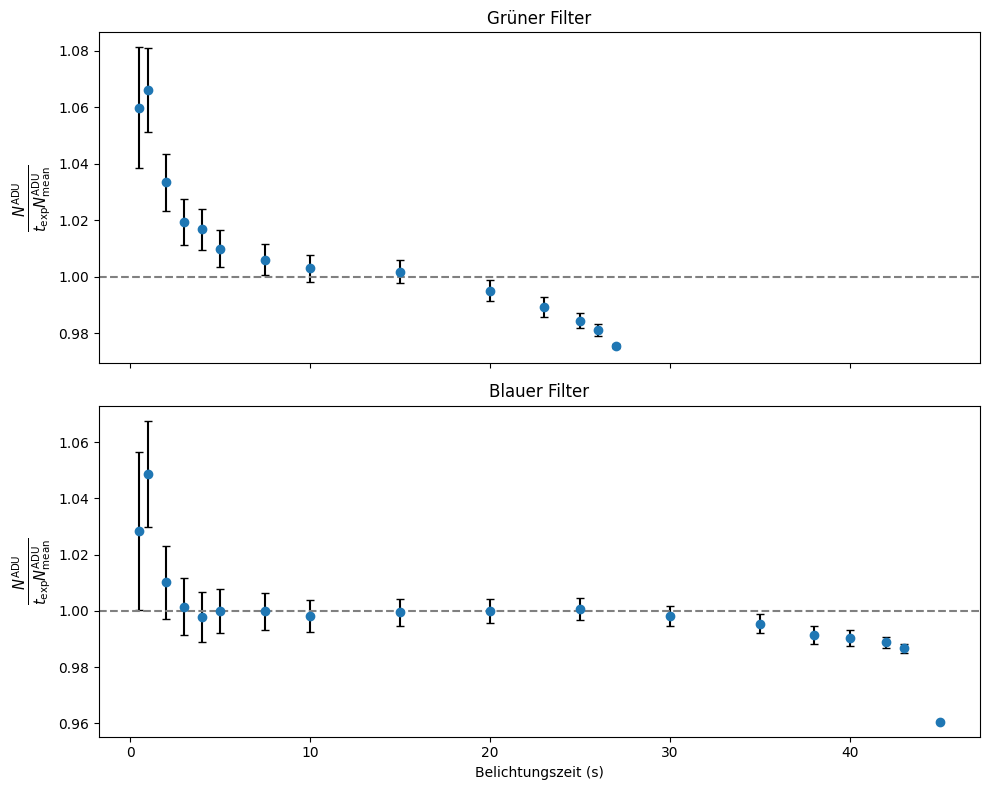

In [15]:
# ================== Ex3 ==================
texp_blue = [0.5, 1, 2, 3, 4, 5, 7.5, 10, 15, 20, 25, 30, 35, 38, 40, 42, 43, 45]
texp_green = [0.5, 1, 2, 3, 4, 5, 7.5, 10, 15, 20, 23, 25, 26, 27]
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
j=0
color = "Green"
means = unp.uarray(np.zeros(len(texp_green)), np.zeros(len(texp_green)))
# load bias
bias = calc_mean(f"biasa_{color}_A4", 7)
for (i, t) in enumerate(texp_green):
  # load flat frame
  flat = load_data(f"{color}_light_A4_{i}.fits")
  flat = flat - bias

  # calculate g factor from mean and std_dev of flat frame cutting out a window
  cutflat = cut_window(flat, 600, 150, 200, 200)
  mean_flat = np.mean(cutflat)
  std_dev_flat = np.std(cutflat)
  means[i] = unc.ufloat(mean_flat, std_dev_flat)
  #print(f"Mean of flat with texp {t}: {mean_flat}")
  #print(f"Standard deviation of flat with texp {t}: {std_dev_flat}")

# norm data using mean of 10, 15, 20s exposure
norm = np.mean(means[7:10]/texp_green[7:10])
newmeans = means / norm.n

ax[j].errorbar(texp_green, unp.nominal_values(newmeans/texp_green), yerr=unp.std_devs(newmeans/texp_green), fmt="o", capsize=3, ecolor="k", label=f"Datenpunkte")
if j == 0:
  ax[j].set_title(f"Grüner Filter")
else:
  ax[j].set_title(f"Blauer Filter")
# dashed line for mean
ax[j].axhline(1, color="gray", linestyle="--")
ax[j].set_ylabel(r"$\frac{N^{\mathrm{ADU}}}{t_{\mathrm{exp}}N^{\mathrm{ADU}}_{\mathrm{mean}}}$", fontsize=15)

j=1
color = "Blue"
means = unp.uarray(np.zeros(len(texp_blue)), np.zeros(len(texp_blue)))
# load bias
bias = calc_mean(f"biasa_{color}_A4", 7)
for (i, t) in enumerate(texp_blue):
  # load flat frame
  flat = load_data(f"{color}_light_A4_{i}.fits")
  flat = flat - bias

  # calculate g factor from mean and std_dev of flat frame cutting out a window
  cutflat = cut_window(flat, 600, 150, 200, 200)
  mean_flat = np.mean(cutflat)
  std_dev_flat = np.std(cutflat)
  means[i] = unc.ufloat(mean_flat, std_dev_flat)
  #print(f"Mean of flat with texp {t}: {mean_flat}")
  #print(f"Standard deviation of flat with texp {t}: {std_dev_flat}")

# norm data using mean of 10, 15, 20s exposure
norm = np.mean(means[8:11]/texp_blue[8:11])
newmeans = means / norm.n

ax[j].errorbar(texp_blue, unp.nominal_values(newmeans/texp_blue), yerr=unp.std_devs(newmeans/texp_blue), fmt="o", capsize=3, ecolor="k", label=f"Datenpunkte")
if j == 0:
  ax[j].set_title(f"Grüner Filter")
else:
  ax[j].set_title(f"Blauer Filter")
# dashed line for mean
ax[j].axhline(1, color="gray", linestyle="--")
ax[j].set_ylabel(r"$\frac{N^{\mathrm{ADU}}}{t_{\mathrm{exp}}N^{\mathrm{ADU}}_{\mathrm{mean}}}$", fontsize=15)

plt.xlabel("Belichtungszeit (s)", fontsize=10)
plt.tight_layout()
# plt.savefig("/home/taco/Documents/fp1/09_CCD/bilder/ex4.pdf", bbox_inches='tight')

# %%

(5.612+/-0.019)e+04
37083.59645654939
Green filter: k = 4.1(3)e-06, g = 2.15(7), c = -0.3(1.2)e+02
Blue filter: k = 4.0(1)e-06, g = 2.33(3), c = 132(32)


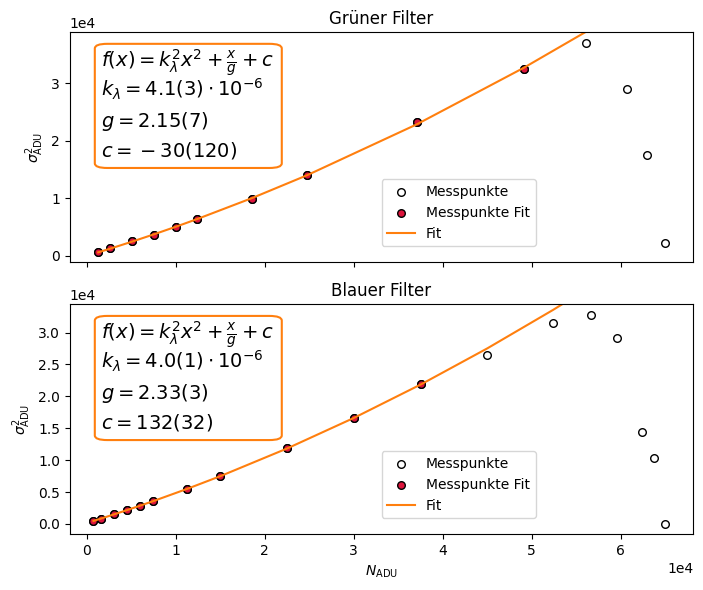

In [22]:
# ================== Ex5 ==================
g2_all = unp.uarray(np.zeros(2), np.zeros(2))
# plot sigma^2 vs mean for green and blue filter
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6))
j=0
color="Green"
means = unp.uarray(np.zeros(len(texp_green)), np.zeros(len(texp_green)))
# load bias
bias = calc_mean(f"biasa_{color}_A4", 7)
for (i, t) in enumerate(texp_green):
  # load flat frame
  flat = load_data(f"{color}_light_A4_{i}.fits")
  flat = flat - bias

  cutflat = cut_window(flat, 600, 150, 200, 200)
  mean_flat = np.mean(cutflat)
  std_dev_flat = np.std(cutflat)
  means[i] = unc.ufloat(mean_flat, std_dev_flat)
  #print(f"Mean of flat with texp {t}: {mean_flat}")
  #print(f"Standard deviati  on of flat with texp {t}: {std_dev_flat}")

# fit parabola to data
stop = 4
print(means[10])
print(unp.std_devs(means[10])** 2)

popt, pcov = curve_fit(parabola, unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, p0=[1e-6, 2, 0])
perr = np.sqrt(np.diag(pcov))
uncpopt = unp.uarray(popt, perr)
print(f"{color} filter: k = {uncpopt[0]:.1uS}, g = {uncpopt[1]:.1uS}, c = {uncpopt[2]:.2uS}")

popt2, pcov2 = curve_fit(parabola2, unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, p0=[1e-6, 0.5])
perr = np.sqrt(np.diag(pcov2))
uncpopt2 = unp.uarray(popt2, perr)
#print(f"{color} filter: k = {uncpopt2[0]:.2uS}, g = {uncpopt2[1]:.1uS}")

g2_all[j] = uncpopt[1]

ax[j].scatter(unp.nominal_values(means), unp.std_devs(means) ** 2, fc="white", ec="k", s=30, lw=1, label="Messpunkte")
ax[j].scatter(unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, fc="crimson", ec="k", s=30, lw=1, label="Messpunkte Fit")
xlims, ylims = ax[j].get_xlim(), ax[j].get_ylim()
ax[j].plot(unp.nominal_values(means), parabola(unp.nominal_values(means), *popt), label="Fit", c="C1")
#ax[j].plot(unp.nominal_values(means), parabola2(unp.nominal_values(means), *popt2), label="Fit", c="C1")

ax[j].text(0.05, 0.85, r"$f(x) = k_\lambda^2 x^2 + \frac{x}{g} + c$", transform=ax[j].transAxes, fontsize=14)
if j == 0:
  ax[j].text(0.05, 0.72, r"$k_\lambda = 4.1(3) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.59, r"$g = 2.15(7)$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.46, r"$c = -30(120)$", transform=ax[j].transAxes, fontsize=14)
else:
  ax[j].text(0.05, 0.72, r"$k_\lambda = 4.0(1) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.59, r"$g = 2.33(3)$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.46, r"$c = 132(32)$", transform=ax[j].transAxes, fontsize=14)
rect = mpl.patches.FancyBboxPatch((0.06, 0.43), 0.26, 0.5, linewidth=1.5, edgecolor="C1", facecolor="none",
                                      transform=ax[j].transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))

# ax[j].text(0.05, 0.85, r"$f(x) = k_\lambda^2 x^2 + \frac{x}{g} + 5.95$", transform=ax[j].transAxes, fontsize=14)
# if j == 0:
#     ax[j].text(0.05, 0.72, r"$k_\lambda = 3.72(12) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
#     ax[j].text(0.05, 0.59, r"$g = 2.13(2)$", transform=ax[j].transAxes, fontsize=14)
# else:
#     ax[j].text(0.05, 0.72, r"$k_\lambda = 2.51(13) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
#     ax[j].text(0.05, 0.59, r"$g = 2.16(2)$", transform=ax[j].transAxes, fontsize=14)
# rect = mpl.patches.FancyBboxPatch((0.06, 0.53), 0.3, 0.4, linewidth=1.5, edgecolor="C1", facecolor="none",
#                                   transform=ax[j].transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax[j].add_patch(rect)

ax[j].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[j].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

if j == 0:
  ax[j].set_title(f"Grüner Filter")
else:
  ax[j].set_title(f"Blauer Filter")
# dashed line for mean
ax[j].set_ylabel(r"$\sigma_{\mathrm{ADU}}^2$", fontsize=10)
ax[j].legend(loc=(0.5, 0.07))
ax[j].set_ylim(ylims)
ax[j].set_xlim(xlims)

j=1
color="Blue"
means = unp.uarray(np.zeros(len(texp_blue)), np.zeros(len(texp_blue)))
# load bias
bias = calc_mean(f"biasa_{color}_A4", 7)
for (i, t) in enumerate(texp_blue):
  # load flat frame
  flat = load_data(f"{color}_light_A4_{i}.fits")
  flat = flat - bias

  cutflat = cut_window(flat, 600, 150, 200, 200)
  mean_flat = np.mean(cutflat)
  std_dev_flat = np.std(cutflat)
  means[i] = unc.ufloat(mean_flat, std_dev_flat)
  #print(f"Mean of flat with texp {t}: {mean_flat}")
  #print(f"Standard deviati  on of flat with texp {t}: {std_dev_flat}")

# fit parabola to data
stop = 7

popt, pcov = curve_fit(parabola, unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, p0=[1e-6, 2, 0])
perr = np.sqrt(np.diag(pcov))
uncpopt = unp.uarray(popt, perr)
print(f"{color} filter: k = {uncpopt[0]:.1uS}, g = {uncpopt[1]:.1uS}, c = {uncpopt[2]:.2uS}")

popt2, pcov2 = curve_fit(parabola2, unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, p0=[1e-6, 0.5])
perr = np.sqrt(np.diag(pcov2))
uncpopt2 = unp.uarray(popt2, perr)
#print(f"{color} filter: k = {uncpopt2[0]:.2uS}, g = {uncpopt2[1]:.1uS}")

g2_all[j] = uncpopt[1]

ax[j].scatter(unp.nominal_values(means), unp.std_devs(means) ** 2, fc="white", ec="k", s=30, lw=1, label="Messpunkte")
ax[j].scatter(unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, fc="crimson", ec="k", s=30, lw=1, label="Messpunkte Fit")
xlims, ylims = ax[j].get_xlim(), ax[j].get_ylim()
ax[j].plot(unp.nominal_values(means), parabola(unp.nominal_values(means), *popt), label="Fit", c="C1")
#ax[j].plot(unp.nominal_values(means), parabola2(unp.nominal_values(means), *popt2), label="Fit", c="C1")

ax[j].text(0.05, 0.85, r"$f(x) = k_\lambda^2 x^2 + \frac{x}{g} + c$", transform=ax[j].transAxes, fontsize=14)
if j == 0:
  ax[j].text(0.05, 0.72, r"$k_\lambda = 4.1(3) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.59, r"$g = 2.15(7)$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.46, r"$c = -30(120)$", transform=ax[j].transAxes, fontsize=14)
else:
  ax[j].text(0.05, 0.72, r"$k_\lambda = 4.0(1) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.59, r"$g = 2.33(3)$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.46, r"$c = 132(32)$", transform=ax[j].transAxes, fontsize=14)
rect = mpl.patches.FancyBboxPatch((0.06, 0.43), 0.26, 0.5, linewidth=1.5, edgecolor="C1", facecolor="none",
                                      transform=ax[j].transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))

# ax[j].text(0.05, 0.85, r"$f(x) = k_\lambda^2 x^2 + \frac{x}{g} + 5.95$", transform=ax[j].transAxes, fontsize=14)
# if j == 0:
#     ax[j].text(0.05, 0.72, r"$k_\lambda = 3.72(12) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
#     ax[j].text(0.05, 0.59, r"$g = 2.13(2)$", transform=ax[j].transAxes, fontsize=14)
# else:
#     ax[j].text(0.05, 0.72, r"$k_\lambda = 2.51(13) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
#     ax[j].text(0.05, 0.59, r"$g = 2.16(2)$", transform=ax[j].transAxes, fontsize=14)
# rect = mpl.patches.FancyBboxPatch((0.06, 0.53), 0.3, 0.4, linewidth=1.5, edgecolor="C1", facecolor="none",
#                                   transform=ax[j].transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax[j].add_patch(rect)

ax[j].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[j].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

if j == 0:
  ax[j].set_title(f"Grüner Filter")
else:
  ax[j].set_title(f"Blauer Filter")
# dashed line for mean
ax[j].set_ylabel(r"$\sigma_{\mathrm{ADU}}^2$", fontsize=10)
ax[j].legend(loc=(0.5, 0.07))
ax[j].set_ylim(ylims)
ax[j].set_xlim(xlims)


plt.xlabel(r"$N_{\mathrm{ADU}}$", fontsize=10)
plt.tight_layout()
# plt.savefig("/home/taco/Documents/fp1/09_CCD/bilder/ex5_2.pdf", bbox_inches='tight')

Green filter: k = 4.16(19)e-06, g = 2.16(4)
Blue filter: k = 3.59(16)e-06, g = 2.24(2)


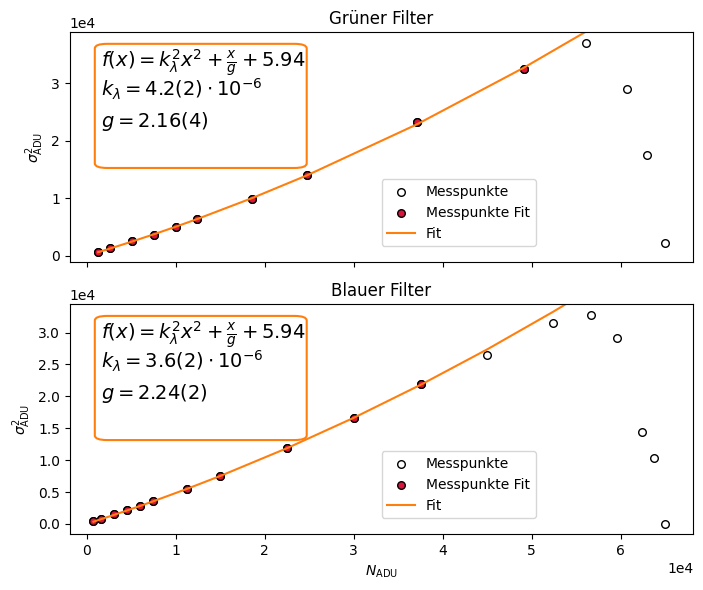

In [17]:
# ================== Ex5 ==================
g2_all = unp.uarray(np.zeros(2), np.zeros(2))
# plot sigma^2 vs mean for green and blue filter
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6))
j=0
color="Green"
means = unp.uarray(np.zeros(len(texp_green)), np.zeros(len(texp_green)))
# load bias
bias = calc_mean(f"biasa_{color}_A4", 7)
for (i, t) in enumerate(texp_green):
  # load flat frame
  flat = load_data(f"{color}_light_A4_{i}.fits")
  flat = flat - bias

  cutflat = cut_window(flat, 600, 150, 200, 200)
  mean_flat = np.mean(cutflat)
  std_dev_flat = np.std(cutflat)
  means[i] = unc.ufloat(mean_flat, std_dev_flat)
  #print(f"Mean of flat with texp {t}: {mean_flat}")
  #print(f"Standard deviati  on of flat with texp {t}: {std_dev_flat}")

# fit parabola to data
stop = 4

popt, pcov = curve_fit(parabola, unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, p0=[1e-6, 2, 0])
perr = np.sqrt(np.diag(pcov))
uncpopt = unp.uarray(popt, perr)
#print(f"{color} filter: k = {uncpopt[0]:.1uS}, g = {uncpopt[1]:.1uS}, c = {uncpopt[2]:.1uS}")

popt2, pcov2 = curve_fit(parabola2, unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, p0=[1e-6, 0.5])
perr = np.sqrt(np.diag(pcov2))
uncpopt2 = unp.uarray(popt2, perr)
print(f"{color} filter: k = {uncpopt2[0]:.2uS}, g = {uncpopt2[1]:.1uS}")

g2_all[j] = uncpopt[1]

ax[j].scatter(unp.nominal_values(means), unp.std_devs(means) ** 2, fc="white", ec="k", s=30, lw=1, label="Messpunkte")
ax[j].scatter(unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, fc="crimson", ec="k", s=30, lw=1, label="Messpunkte Fit")
xlims, ylims = ax[j].get_xlim(), ax[j].get_ylim()
#ax[j].plot(unp.nominal_values(means), parabola(unp.nominal_values(means), *popt), label="Fit", c="C1")
ax[j].plot(unp.nominal_values(means), parabola2(unp.nominal_values(means), *popt2), label="Fit", c="C1")

ax[j].text(0.05, 0.85, r"$f(x) = k_\lambda^2 x^2 + \frac{x}{g} + 5.94$", transform=ax[j].transAxes, fontsize=14)
if j == 0:
  ax[j].text(0.05, 0.72, r"$k_\lambda = 4.2(2) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.59, r"$g = 2.16(4)$", transform=ax[j].transAxes, fontsize=14)
  #ax[j].text(0.05, 0.46, r"$c = -30(90)$", transform=ax[j].transAxes, fontsize=14)
else:
  ax[j].text(0.05, 0.72, r"$k_\lambda = 3.6(2) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.59, r"$g = 2.24(2)$", transform=ax[j].transAxes, fontsize=14)
  #ax[j].text(0.05, 0.46, r"$c = -30(90)$", transform=ax[j].transAxes, fontsize=14)
rect = mpl.patches.FancyBboxPatch((0.06, 0.43), 0.3, 0.5, linewidth=1.5, edgecolor="C1", facecolor="none",
                                      transform=ax[j].transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))

# ax[j].text(0.05, 0.85, r"$f(x) = k_\lambda^2 x^2 + \frac{x}{g} + 5.95$", transform=ax[j].transAxes, fontsize=14)
# if j == 0:
#     ax[j].text(0.05, 0.72, r"$k_\lambda = 3.72(12) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
#     ax[j].text(0.05, 0.59, r"$g = 2.13(2)$", transform=ax[j].transAxes, fontsize=14)
# else:
#     ax[j].text(0.05, 0.72, r"$k_\lambda = 2.51(13) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
#     ax[j].text(0.05, 0.59, r"$g = 2.16(2)$", transform=ax[j].transAxes, fontsize=14)
# rect = mpl.patches.FancyBboxPatch((0.06, 0.53), 0.3, 0.4, linewidth=1.5, edgecolor="C1", facecolor="none",
#                                   transform=ax[j].transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax[j].add_patch(rect)

ax[j].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[j].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

if j == 0:
  ax[j].set_title(f"Grüner Filter")
else:
  ax[j].set_title(f"Blauer Filter")
# dashed line for mean
ax[j].set_ylabel(r"$\sigma_{\mathrm{ADU}}^2$", fontsize=10)
ax[j].legend(loc=(0.5, 0.07))
ax[j].set_ylim(ylims)
ax[j].set_xlim(xlims)

j=1
color="Blue"
means = unp.uarray(np.zeros(len(texp_blue)), np.zeros(len(texp_blue)))
# load bias
bias = calc_mean(f"biasa_{color}_A4", 7)
for (i, t) in enumerate(texp_blue):
  # load flat frame
  flat = load_data(f"{color}_light_A4_{i}.fits")
  flat = flat - bias

  cutflat = cut_window(flat, 600, 150, 200, 200)
  mean_flat = np.mean(cutflat)
  std_dev_flat = np.std(cutflat)
  means[i] = unc.ufloat(mean_flat, std_dev_flat)
  #print(f"Mean of flat with texp {t}: {mean_flat}")
  #print(f"Standard deviati  on of flat with texp {t}: {std_dev_flat}")

# fit parabola to data
stop = 7

popt, pcov = curve_fit(parabola, unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, p0=[1e-6, 2, 0])
perr = np.sqrt(np.diag(pcov))
uncpopt = unp.uarray(popt, perr)
#print(f"{color} filter: k = {uncpopt[0]:.1uS}, g = {uncpopt[1]:.1uS}, c = {uncpopt[2]:.1uS}")

popt2, pcov2 = curve_fit(parabola2, unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, p0=[1e-6, 0.5])
perr = np.sqrt(np.diag(pcov2))
uncpopt2 = unp.uarray(popt2, perr)
print(f"{color} filter: k = {uncpopt2[0]:.2uS}, g = {uncpopt2[1]:.1uS}")

g2_all[j] = uncpopt[1]

ax[j].scatter(unp.nominal_values(means), unp.std_devs(means) ** 2, fc="white", ec="k", s=30, lw=1, label="Messpunkte")
ax[j].scatter(unp.nominal_values(means[:-stop]), unp.std_devs(means[:-stop]) ** 2, fc="crimson", ec="k", s=30, lw=1, label="Messpunkte Fit")
xlims, ylims = ax[j].get_xlim(), ax[j].get_ylim()
#ax[j].plot(unp.nominal_values(means), parabola(unp.nominal_values(means), *popt), label="Fit", c="C1")
ax[j].plot(unp.nominal_values(means), parabola2(unp.nominal_values(means), *popt2), label="Fit", c="C1")

ax[j].text(0.05, 0.85, r"$f(x) = k_\lambda^2 x^2 + \frac{x}{g} + 5.94$", transform=ax[j].transAxes, fontsize=14)
if j == 0:
  ax[j].text(0.05, 0.72, r"$k_\lambda = 4.2(2) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.59, r"$g = 2.16(4)$", transform=ax[j].transAxes, fontsize=14)
  #ax[j].text(0.05, 0.46, r"$c = -30(90)$", transform=ax[j].transAxes, fontsize=14)
else:
  ax[j].text(0.05, 0.72, r"$k_\lambda = 3.6(2) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
  ax[j].text(0.05, 0.59, r"$g = 2.24(2)$", transform=ax[j].transAxes, fontsize=14)
  #ax[j].text(0.05, 0.46, r"$c = -30(90)$", transform=ax[j].transAxes, fontsize=14)
rect = mpl.patches.FancyBboxPatch((0.06, 0.43), 0.3, 0.5, linewidth=1.5, edgecolor="C1", facecolor="none",
                                      transform=ax[j].transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))

# ax[j].text(0.05, 0.85, r"$f(x) = k_\lambda^2 x^2 + \frac{x}{g} + 5.95$", transform=ax[j].transAxes, fontsize=14)
# if j == 0:
#     ax[j].text(0.05, 0.72, r"$k_\lambda = 3.72(12) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
#     ax[j].text(0.05, 0.59, r"$g = 2.13(2)$", transform=ax[j].transAxes, fontsize=14)
# else:
#     ax[j].text(0.05, 0.72, r"$k_\lambda = 2.51(13) \cdot 10^{-6}$", transform=ax[j].transAxes, fontsize=14)
#     ax[j].text(0.05, 0.59, r"$g = 2.16(2)$", transform=ax[j].transAxes, fontsize=14)
# rect = mpl.patches.FancyBboxPatch((0.06, 0.53), 0.3, 0.4, linewidth=1.5, edgecolor="C1", facecolor="none",
#                                   transform=ax[j].transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax[j].add_patch(rect)

ax[j].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[j].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

if j == 0:
  ax[j].set_title(f"Grüner Filter")
else:
  ax[j].set_title(f"Blauer Filter")
# dashed line for mean
ax[j].set_ylabel(r"$\sigma_{\mathrm{ADU}}^2$", fontsize=10)
ax[j].legend(loc=(0.5, 0.07))
ax[j].set_ylim(ylims)
ax[j].set_xlim(xlims)


plt.xlabel(r"$N_{\mathrm{ADU}}$", fontsize=10)
plt.tight_layout()
# plt.savefig("/home/taco/Documents/fp1/09_CCD/bilder/ex5_2.pdf", bbox_inches='tight')

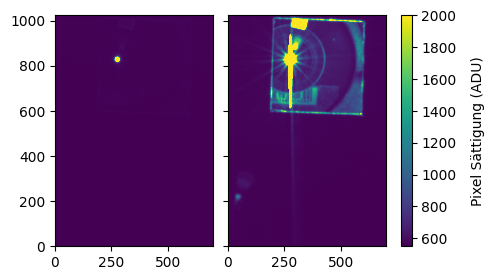

In [18]:
# ================== Blooming ==================
# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=.15,
                 )
for (i, ax) in enumerate(grid):
    # load data
    data = load_data(f"bloomboom_A7_{i}.fits")
    # cut out a window
    data = cut_window(data, 600, 0, 700, h)
    # plot data
    im = ax.imshow(data, cmap="viridis", origin="lower", vmin=550, vmax=2000)

thecb = ax.cax.colorbar(im)
thecb.set_label("Pixel Sättigung (ADU)", labelpad=10)

# plt.savefig("/home/taco/Documents/fp1/09_CCD/bilder/blooming.pdf", bbox_inches='tight')

Mean g factor: 2.24(4)
Standard deviation of readout noise: 13.28+/-0.22
[12] [111024.34285714]
0.030+/-0.018
[ 12 163] [1.12036886e+05 7.25714286e+00]
0.031+/-0.023
[ 13 200] [1.11429486e+05 2.92571429e+01]
0.05+/-0.04
[ 17 250 602] [1.06685943e+05 4.68571429e+01 1.46285714e+01]
0.07+/-0.08
[ 21 320 650] [1.03468286e+05 4.94285714e+01 1.31142857e+01]
0.17+/-0.17
[  53  838 1465] [7.58432559e+04 2.25894428e+01 7.69410456e+00]
0.43+/-0.25


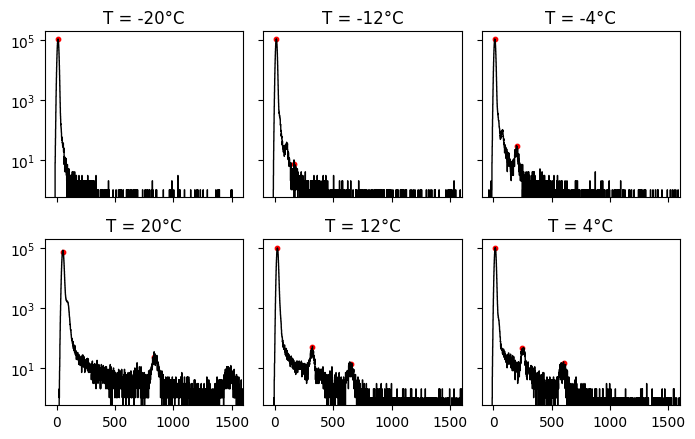

In [19]:
# ================== Ex6 ==================
g_mean = np.mean(g2_all)
std_ron_e = g_mean * std_ron
print(f"Mean g factor: {g_mean:.1uS}")
print(f"Standard deviation of readout noise: {std_ron_e}")
# %%
from scipy.signal import find_peaks, savgol_filter
# ================== Ex7 ==================
Temps = np.array([-20, -12, -4, 4, 12, 20])
texp = [180, 180, 120, 120, 60, 60]
temp = unp.uarray(np.zeros(len(Temps)), np.zeros(len(Temps)))
dark_hist_all = np.zeros((len(Temps), 1700))
peakarr = []
fig, ax = plt.subplots(2, 3, figsize=(7, 4.5), sharex=True, sharey=True)
for (i, T) in enumerate(Temps[0:6]):
    # load bias
    bias = calc_mean(f"biasa_T{T}", 7)
    # load dark frames
    dark = calc_mean(f"A8_dark_T{T}", 2, start=0)
    dark = dark - bias

    # plot
    # if i == 2:
    #     fig, ax = plt.subplots(2, 1, figsize=(7, 6))
    #     plot_data(ax[0], dark)
    #     plot_hist(ax[1], dark)
    #     ax[0].set_title(f"Temperatur: {T}°C")
    #     # ax[1].set_yscale("log")

    # fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    if i < 3:
        myax = ax[0, i]
    else:
        myax = ax[1, 5-i]

    # find peaks in histogram
    histarr = np.histogram(dark.flatten(), bins=range(65535))[0][:1700]
    # smooth data
    if i < 3:
        histarr = savgol_filter(histarr, 5, 3)
        peaks, _ = find_peaks(histarr, height=5, threshold=1, prominence=5, distance=60)
    elif i < 5:
        histarr = savgol_filter(histarr, 5, 2)
        peaks, _ = find_peaks(histarr, height=10, threshold=1, prominence=1, distance=150)
    else:
        histarr = savgol_filter(histarr, 31, 3)
        peaks, _ = find_peaks(histarr, height=5, distance=350, prominence=3)
    print(peaks, histarr[peaks])
    peakarr.append(peaks)
    myax.scatter(peaks, histarr[peaks], color="red", s=10)
    # myax.plot(histarr, color="black")

    plot_hist(myax, dark)
    myax.set_title(f"T = {T}°C")
    myax.set_yscale("log")
    myax.set_xlim(-100, 1600)
    # myax.set_ylim(1, 1e5)

    dark_hist_all[i] = np.histogram(dark.flatten(), bins=range(65535), density=True)[0][:1700]

    # exclude pixels with values > 10000
    dark = dark[~(dark > 1000)]
    # calculate dark current
    mean_dark = unc.ufloat(np.mean(dark), np.std(dark))/(texp[i]*g_mean)
    print(mean_dark)
    temp[i] = mean_dark

plt.tight_layout()
Temps = Temps + 273.15

[-6559.53196647    12.84558758]
E_g = 1.1(2)
b = 13(4)
[197.10473723 -12.5735755 ]
E_g2 = -0.033970344165752765
b2 = -12.57357550445975
(0.003384272712685926, 0.003977177348792558)


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


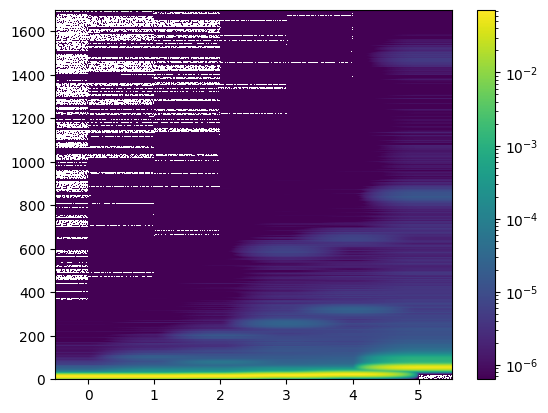

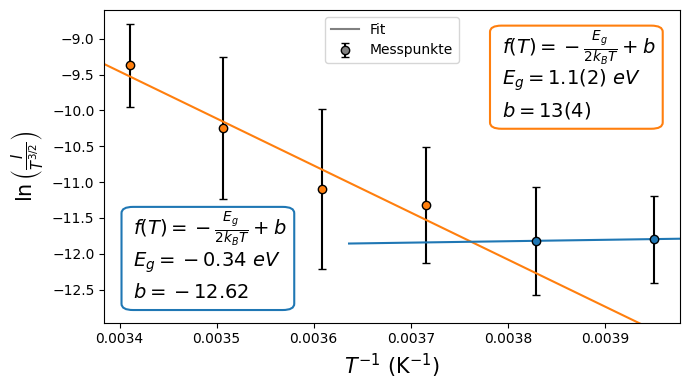

In [20]:
# plt imshow of dark current histograms
fig, ax = plt.subplots()
ax.imshow(dark_hist_all.T, cmap="viridis", origin="lower", aspect="auto", norm=mpl.colors.LogNorm())
plt.colorbar(ax.images[0], ax=ax)
# %%
y = unp.log(temp/Temps**(3/2))
# y = temp/Temps**(3/2)
x = 1/Temps

# fit line to data
popt, pcov = curve_fit(line, x[2:], unp.nominal_values(y[2:]), p0=[-8000, 20])
perr = np.sqrt(np.diag(pcov))
uncpopt = unp.uarray(popt, perr)
print(popt)
E_g = -uncpopt[0]*(2*8.617333262145e-5) # eV
print(f"E_g = {E_g:.1uS}")
print(f"b = {uncpopt[1]:.1uS}")
popt2, pcov2 = curve_fit(line, x[:2], unp.nominal_values(y[:2]), p0=[-8000, 20])
perr = np.sqrt(np.diag(pcov2))
print(popt2)
E_g2 = -popt2[0]*(2*8.617333262145e-5) # eV
print(f"E_g2 = {E_g2}")
print(f"b2 = {popt2[1]}")

newx = np.linspace(0.0025, 0.005, 100)

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(1/Temps[2:], unp.nominal_values(y[2:]), yerr=unp.std_devs(y[2:]), fmt="o", capsize=3, ecolor="k", mfc="C1", mec="k")
ax.errorbar(1/Temps[:2], unp.nominal_values(y[:2]), yerr=unp.std_devs(y[:2]), fmt="o", capsize=3, ecolor="k", mfc="C0", mec="k")
xlims, ylims = ax.get_xlim(), ax.get_ylim()

ax.plot(newx, line(newx, *popt), c="C1")
ax.plot(newx[45:], line(newx[45:], *popt2), c="C0")

ax.text(0.69, 0.86, r"$f(T) = -\frac{E_g}{2k_BT} + b$", transform=ax.transAxes, fontsize=14)
ax.text(0.69, 0.76, r"$E_g = 1.1(2)\ eV$", transform=ax.transAxes, fontsize=14)
ax.text(0.69, 0.66, r"$b = 13(4)$", transform=ax.transAxes, fontsize=14)
rect = mpl.patches.FancyBboxPatch((0.69, 0.64), 0.26, 0.29, linewidth=1.5, edgecolor="C1", facecolor="none",
                                      transform=ax.transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax.add_patch(rect)

ax.text(0.05, 0.28, r"$f(T) = -\frac{E_g}{2k_BT} + b$", transform=ax.transAxes, fontsize=14)
ax.text(0.05, 0.18, r"$E_g = -0.34\ eV$", transform=ax.transAxes, fontsize=14)
ax.text(0.05, 0.08, r"$b = -12.62$", transform=ax.transAxes, fontsize=14)
rect = mpl.patches.FancyBboxPatch((0.05, 0.06), 0.26, 0.29, linewidth=1.5, edgecolor="C0", facecolor="none",
                                      transform=ax.transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax.add_patch(rect)

# add legend
ax.errorbar(0, 0, yerr=0, fmt="o", capsize=3, ecolor="k", mfc="gray", mec="k", label="Messpunkte")
ax.plot([-1, 0], [-1, 0], c="gray", label="Fit")

print(xlims)
ax.set_xlim(xlims)
ax.set_ylim(ylims[0]-0.2, ylims[1])
ax.set_xlabel(r"$T^{-1}\ (\mathrm{K}^{-1})$", fontsize=15)
ax.set_ylabel(r"$\ln\left(\frac{I}{T^{3/2}}\right)$", fontsize=15)

plt.legend(loc="upper center")
plt.tight_layout()
# plt.savefig("/home/taco/Documents/fp1/09_CCD/bilder/ex7.pdf", bbox_inches='tight')

[12]
[ 12 163]
[ 13 200]
[ 17 250 602]
[ 21 320 650]
[  53  838 1465]


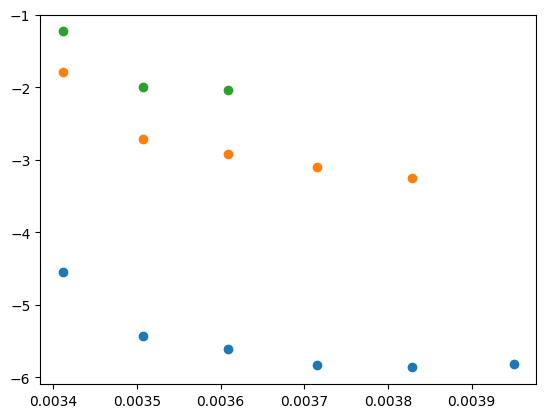

In [21]:
# Temps = Temps + 273.15

# y = temp/Temps**(3/2)
x = 1/Temps
# print(peakarr)
# plot peaks
for (i, peaks) in enumerate(peakarr):
    print(peaks)
    for (j, peak) in enumerate(peaks):
        y = np.log(peak / Temps[i] ** (3 / 2))
        plt.scatter(x[i], y, c=f"C{j}")